<center><big><big><big>The Annotated GPT-2</big></big></big></center>
<big>May 9, 2021</big>

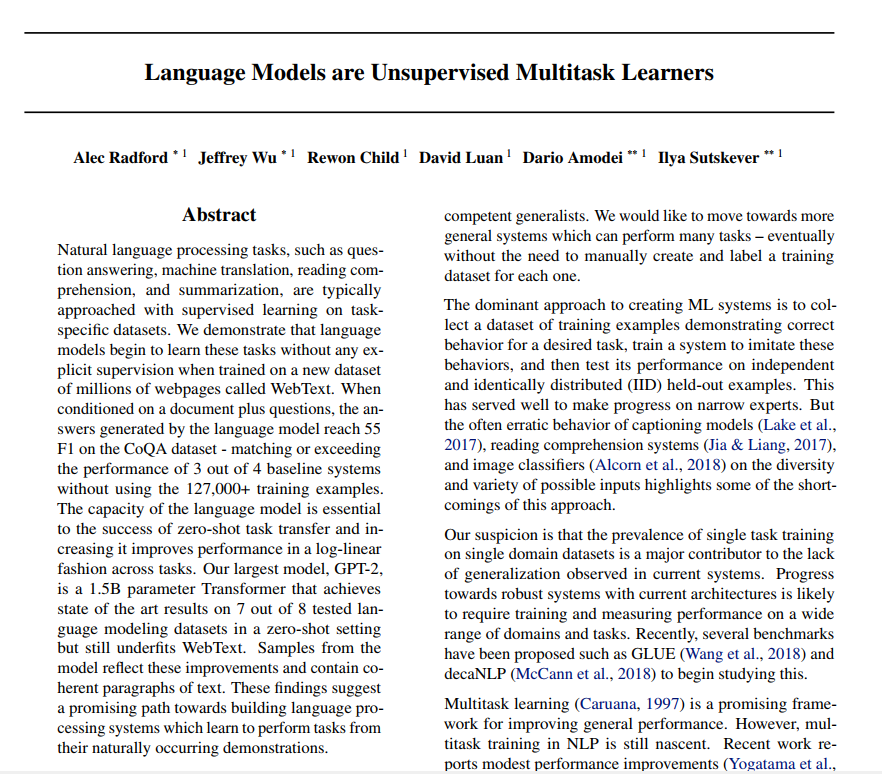

In [1]:
from IPython.display import Image
Image(filename='images/Abstract.PNG')

<big>
This year, we saw a dazzling application of machine learning. The OpenAI GPT-2 exhibited impressive ability of writing coherent and passionate essays that exceed what we anticipated current language models are able to produce. The GPT-2 wasn’t a particularly novel architecture – it’s architecture is very similar to the decoder-only transformer. The GPT2 was, however, a very large, transformer-based language model trained on a massive dataset. In this post, we'll look at the architecture that enabled the model to produce its results. We will go into the depths of its self-attention layer. And then we'll look at applications for the decoder-only transformer beyond language modeling.

To follow along you will first need to install [PyTorch](https://pytorch.org/get-started/previous-versions/). The complete notebook is also available on [github](https://github.com/wzy6642/GPT-2-Tutorials) or on Google [Colab](https://colab.research.google.com/drive/12RHUqxUffGz7-qGIGrbLvLkPZmfcl9tQ?usp=sharing) with free GPUs.
</big>

# Prelims

In [2]:
import math
import logging
import random
import multiprocessing

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset

# set up logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s", 
    datefmt="%m/%d/%Y %H:%M:%S", 
    level=logging.INFO, 
)
print('version of PyTorch: {}'.format(torch.__version__))

version of PyTorch: 1.8.1+cu101


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# make deterministic
set_seed(2021)

# Background

<big>
Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End- to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple- language question answering and language modeling tasks.

In this article, we take two-digit addition as an example to analyze the training and prediction process of GPT-2.
</big>

# Training Data and Batching 

<big>
In this article, we take two-digit addition as an example to analyze the training and prediction process of GPT-2. We use a sequence to represent the addition operation. Take 3+2=5 as an example. First, we need to express the addend and sum to the same length, that is, 03+02=005. Then, we convert the three numbers into a sequence and concatenate them to [0, 3, 0, 2, 0, 0, 5].  Our training goal is to make the model output [0, 0, 5] when it takes [0, 3, 0, 2] as input.
</big>

In [4]:
class AdditionDataset(Dataset):
    """
    function: 
        Returns addition problems of up to some number of digits in the inputs. Recall
        that all GPT cares about are sequences of integers, and completing them according to
        patterns in the data. Therefore, we have to somehow encode addition problems
        as a sequence of integers.
    parameters:
        ndigit - n-digit addition 
        split - train/test
    returns:
        x - feature
        y - label
    example:
        85 + 50 = 135 becomes the sequence [8, 5, 5, 0, 1, 3, 5]
        6 + 39 = 45   becomes the sequence [0, 6, 3, 9, 0, 4, 5]
        given [8, 5, 5, 0] to infer [1, 3, 5]
    date:
        May 9, 2021
    """
    
    def __init__(self, ndigit, split):
        self.split = split    # train/test
        self.ndigit = ndigit
        self.vocab_size = 10  # 10 possible digits 0..9
        self.block_size = ndigit + ndigit + ndigit + 1
        
        # split up all addition problems into either training data or test data
        # total number of possible combinations
        num = (10**self.ndigit)**2
        # make deterministic
        r = np.random.RandomState(2021)
        # randomize a sequence
        perm = r.permutation(num)
        # number of test set samples
        num_test = min(int(num*0.2), 1000)
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]
        
    def __len__(self):
        return self.ixes.size
    
    def __getitem__(self, idx):
        # given a problem index idx, first recover the associates a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx % nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a, b, c)    # e.g. 03+25=28 becomes "0325028"
        dix = [int(s) for s in render]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        y[:self.ndigit*2-1] = -100  # we will only train in the output locations. -100 will mask loss to zero
        return x, y

In [5]:
# create a dataset for e.g. 2-digit addition
ndigit = 2
train_dataset = AdditionDataset(ndigit=ndigit, split='train')
test_dataset = AdditionDataset(ndigit=ndigit, split='test')
# sample a training instance just to see what one raw example looks like
train_dataset[0]

(tensor([0, 3, 5, 9, 0, 6]), tensor([-100, -100, -100,    0,    6,    2]))

# Model Architecture

<big>
Given an unsupervised corpus of tokens $\mathcal{U}=\left\{u_{1}, \ldots, u_{n}\right\}$, we use a standard language modeling
objective to maximize the following likelihood:

$
L_{1}(\mathcal{U})=\sum_{i} \log P\left(u_{i} \mid u_{i-k}, \ldots, u_{i-1} ; \Theta\right)
$

where $k$ is the size of the context window, and the conditional probability $P$ is modeled using a neural network with parameters $\Theta$. These parameters are trained using stochastic gradient descent.

In our experiments, we use a multi-layer Transformer decoder for the language model, which is a variant of the transformer. This model applies a multi-headed self-attention operation over the input context tokens followed by position-wise feedforward layers to produce an output distribution over target tokens:

$
\begin{aligned}
h_{0} &=U W_{e}+W_{p} \\
h_{l} &=\text { transformer_block }\left(h_{l-1}\right) \forall i \in[1, n] \\
P(u) &=\operatorname{softmax}\left(h_{n} W_{e}^{T}\right)
\end{aligned}
$

where $U=\left(u_{-k}, \ldots, u_{-1}\right)$ is the context vector of tokens, $n$ is the number of layers, $W_{e}$ is the token
embedding matrix, and $W_{p}$ is the position embedding matrix.
</big>

## Attention

<big>
    An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.
    
   We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.
</big>

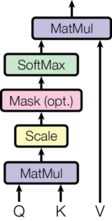

In [6]:
Image(filename='images/Attention.png')

<big>
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$. In this work we employ $h=4$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=32$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.
</big>

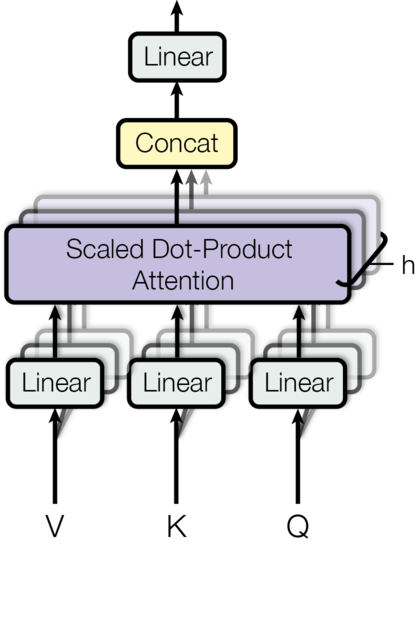

In [7]:
Image(filename='images/Multihead.png')

<big>
We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.
</big>

In [8]:
def casual_mask(size):
    block_size = size
    casual_mask = torch.tril(torch.ones(block_size, block_size).view(1, 1, block_size, block_size))
    return casual_mask

> <big><font color=#ea4335>Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.</font></big>

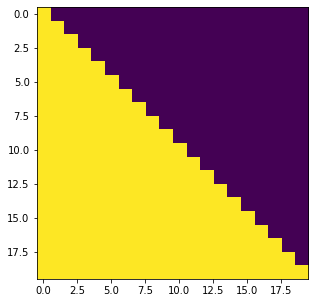

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(casual_mask(20)[0][0])
plt.show()

In [10]:
class CasualSelfAttention(nn.Module):
    """
    function: 
        A vanilla multi-head masked self-attention layer with a projection at the end.
    parameters:
        config - parameters configuration
            - n_embd: embedding dimension
            - n_head: number of attention heads
            - attn_pdrop: dropout probability of the attention layer
            - resid_pdrop: dropout probability of the residual connection layer
            - block_size: sequence length
    returns:
        y - calculation results of the attention layer (B, T, C)
    date:
        May 9, 2021
    """
    
    def __init__(self, config):
        super().__init__()
        # The embedding dimension should be able to divide the number of attention heads 
        assert config.n_embd % config.n_head == 0                       
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # casual mask to ensure that attention is only applied to the left in the input sequence
        # you want a stateful part of your model that is not a parameter, but you want it in your state_dict
        # registered buffers are Tensors (not Variables)
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                               .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        
    def forward(self, x, layer_past=None):
        # B: batch size
        # T: sequence length
        # C: embedding dimensions
        B, T, C = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh * hs = C
        k = self.key(x).view(B, T, self.n_head, C//self.n_head).transpose(1, 2)    # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C//self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C//self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        
        # casual self-attention; self-attend: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Fills elements of self tensor with value where mask is True. 
        # The shape of mask must be broadcastable with the shape of the underlying tensor.
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        # If you want to view every attention matrix, please return tensor y. 
        y = att @ v   # (B, nh, T, T) * (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # output projection
        y = self.resid_drop(self.proj(y))
        return y

## Position-wise Feed-Forward Networks

<big>
In addition to attention sub-layers, each of the layers in our decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a GELU activation in between.

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_{\text{model}}=128$, and the inner-layer has dimensionality $d_{ff}=512$.
</big>

In [11]:
class PositionwiseFeedForward(nn.Module):
    """
    function: 
        Feedforward neural network composed of multi-layer perceptrons.
    parameters:
        config - parameters configuration
            - n_embd: embedding dimension
            - resid_pdrop: dropout probability of the residual connection layer
    returns:
        calculation results of the feedforward layer (B, T, C)
    date:
        May 9, 2021
    """
    
    def __init__(self, config):
        super().__init__()
        self.li1 = nn.Linear(config.n_embd, 4*config.n_embd)
        self.act = nn.GELU()
        self.li2 = nn.Linear(4*config.n_embd, config.n_embd)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        
    def forward(self, x):
        return self.resid_drop(self.li2(self.act(self.li1(x))))

## Decoder 

<big>
The decoder is composed of a stack of $N=2$ identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.
</big>

In [12]:
class Block(nn.Module):
    """
    function: 
        Decoder module for GPT-2.
    parameters:
        config - parameters configuration
            - n_embd: embedding dimension
    returns:
        calculation results of the decoder layer (B, T, C)
    date:
        May 9, 2021
    """
    
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CasualSelfAttention(config)
        self.mlp = PositionwiseFeedForward(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

##  Parameters Configuration

In [13]:
class GPTConfig:
    """
    function: 
        GPT model parameters configuration.
    parameters:
        embd_pdrop - embedded layer dropout probability
        resid_pdrop - dropout probability of the residual connection layer
        attn_pdrop - dropout probability of the attention layer
        vocab_size - word list size
        block_size - sequence length
    returns:
        None
    date:
        May 9, 2021
    """
    
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    
    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

In [14]:
class GPT1Config(GPTConfig):
    """
    function: 
        GPT-1 model parameters configuration.
    parameters:
        n_layer - number of decoders
        n_head - number of attention heads
        n_embed - embedding dimension
    returns:
        None
    date:
        May 9, 2021
    """
    
    n_layer = 12
    n_head = 12
    n_embed = 768

## Full Model 

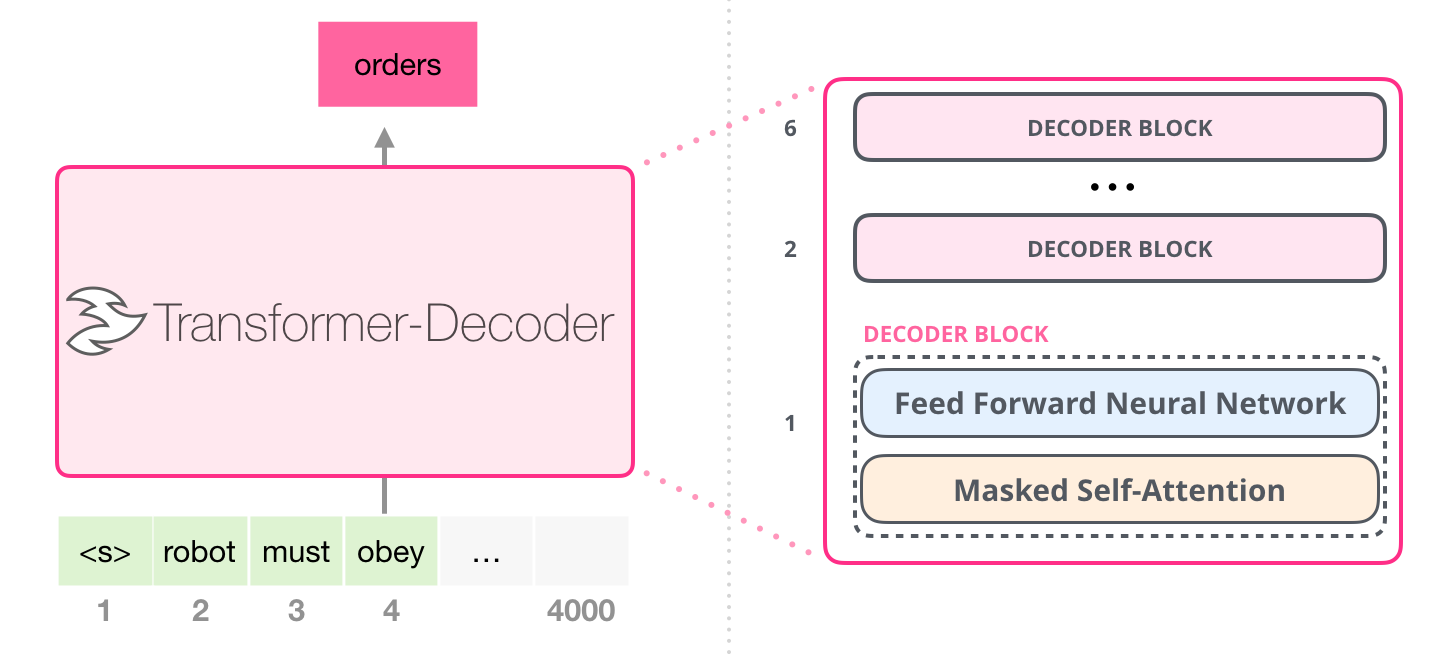

In [15]:
Image(filename='images/GPT.png')

In [16]:
class GPT(nn.Module):
    """
    function: 
        The full GPT language model, with a context size of block_size.
    parameters:
        None
    returns:
        loss
    date:
        May 9, 2021
    """
    
    def __init__(self, config):
        super().__init__()
        
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        self.block_size = config.block_size
        self.apply(self._init_weights)
        
        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))
        
    def get_block_size(self):
        return self.block_size
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            
    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive: 
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """
        
        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of thitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weighted decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" % (
            str(param_dict.keys() - union_params), )

        # create the PyTorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay}, 
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer
    
    def forward(self, idx, targets=None):
        # b: batch size
        # t: sequence length
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        
        # forward the GPT model
        token_embeddings = self.tok_emb(idx)            # each index maps to a learnable vector
        position_ids = torch.arange(t, dtype=torch.long, device=idx.device)
        position_ids = position_ids.unsqueeze(0).expand_as(idx)
        position_embeddings = self.pos_emb(position_ids)    # each position maps to a learnable vector
        x = self.drop(token_embeddings+position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            
        return logits, loss

In [17]:
# initialize a baby GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=2, n_head=4, n_embd=128)
model = GPT(mconf)

05/10/2021 00:12:07 - INFO - __main__ -   number of parameters: 4.002560e+05


# Training Loop

In [18]:
class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1        # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6
    final_tokens = 260e9
    # checkpoint settings
    ckpt_path = None
    num_workers = 0           # for DataLoader
    
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

In [19]:
class Trainer:
    
    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        
        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)
            
    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.model if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)
        
    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)
        
        def run_epoch(split):
            is_train = split == "train"
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True, 
                                batch_size=config.batch_size, 
                                num_workers=config.num_workers)
            
            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:
                
                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)
                
                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean()   # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())
                    
                if is_train:
                    
                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()
                    
                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(
                                max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

In [20]:
tconf = TrainerConfig(max_epochs=50, batch_size=512, learning_rate=6e-4, 
                      lr_decay=True, warmup_tokens=1024, final_tokens=50*len(train_dataset)*(ndigit+1), 
                      num_workers=0)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 17: train loss 1.61816. lr 5.994512e-04: 100%|██████████| 18/18 [00:00<00:00, 19.86it/s]
05/10/2021 00:12:19 - INFO - __main__ -   test loss: 1.563635
epoch 2 iter 17: train loss 1.39309. lr 5.977197e-04: 100%|██████████| 18/18 [00:00<00:00, 28.40it/s]
05/10/2021 00:12:19 - INFO - __main__ -   test loss: 1.315651
epoch 3 iter 17: train loss 1.26973. lr 5.948114e-04: 100%|██████████| 18/18 [00:00<00:00, 28.77it/s]
05/10/2021 00:12:20 - INFO - __main__ -   test loss: 1.199532
epoch 4 iter 17: train loss 1.21233. lr 5.907379e-04: 100%|██████████| 18/18 [00:00<00:00, 29.49it/s]
05/10/2021 00:12:21 - INFO - __main__ -   test loss: 1.130462
epoch 5 iter 17: train loss 1.14960. lr 5.855153e-04: 100%|██████████| 18/18 [00:00<00:00, 29.67it/s]
05/10/2021 00:12:21 - INFO - __main__ -   test loss: 1.077796
epoch 6 iter 17: train loss 0.96310. lr 5.791641e-04: 100%|██████████| 18/18 [00:00<00:00, 30.62it/s]
05/10/2021 00:12:22 - INFO - __main__ -   test loss: 0.850160
epoch 7 iter 17:

# Decoding

In [21]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

In [22]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):  
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:]   # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)
        
    return x

In [23]:
# now let's give the trained model an addition exam
def give_exam(dataset, batch_size=32, max_batches=-1):
    
    results = []
    loader = DataLoader(dataset, batch_size=batch_size)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        d1d2 = x[:, :ndigit*2]
        d1d2d3 = sample(model, d1d2, ndigit+1)
        d3 = d1d2d3[:, -(ndigit+1):]
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        # decode the integers from individual digits
        d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
        d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
        d3i_pred = (d3 * factors).sum(1)
        d3i_gt = d1i + d2i
        correct = (d3i_pred == d3i_gt).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line, lol
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            judge = 'YEP!!!' if correct[i] else 'NOPE'
            if not correct[i]:
                print("GPT claims that %03d + %03d = %03d (gt is %03d; %s)" 
                      % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i], judge))
        
        if max_batches >= 0 and b+1 >= max_batches:
            break

    print("final score: %d/%d = %.2f%% correct" % (np.sum(results), len(results), 100*np.mean(results)))

In [24]:
# training set: how well did we memorize?
give_exam(train_dataset, batch_size=1024, max_batches=10)

GPT claims that 005 + 095 = 090 (gt is 100; NOPE)
GPT claims that 045 + 055 = 090 (gt is 100; NOPE)
final score: 8998/9000 = 99.98% correct


In [25]:
# test set: how well did we generalize?
give_exam(test_dataset, batch_size=1024, max_batches=-1)

final score: 1000/1000 = 100.00% correct


In [26]:
# well that's amusing... our model learned everything except 55 + 45

In [27]:
d1, d2 = '01', '55'
d1_ = torch.tensor([int(i) for i in str(d1)]).unsqueeze(0)
d2_ = torch.tensor([int(i) for i in str(d2)]).unsqueeze(0)
d1d2 = torch.cat((d1_, d2_), dim=-1).to('cuda')
d3 = sample(model, d1d2, ndigit+1).tolist()[0][-3:]
print("{}+{}={}".format(d1, d2, d3[0]*10**2+d3[1]*10**1+d3[2]*10**0))

01+55=56


# A Real World Example

> <big><font color=#ea4335>The inputs here are simple text files, which we chop up to individual characters and then train GPT on. So you could say this is a char-transformer instead of a char-rnn. Doesn't quite roll off the tongue as well. In this example we will feed it some Shakespeare, which we'll get it to predict character-level.</font></big>

## Data Loading 

In [28]:
class CharDataset(Dataset):
    """
    arrange data and targets so that the first i elements of x
    will be asked to predict the i-th element of y. Notice that
    the eventual language model will actually make block_size
    individual predictions at the same time based on this data,
    so we are being clever and amortizing the cost of the forward
    pass of the network. So for example if block_size is 4, then
    we could e.g. sample a chunk of text "hello", the integers in
    x will correspond to "hell" and in y will be "ello". This will
    then actually "multitask" 4 separate examples at the same time
    in the language model:
    - given just "h", please predict "e" as next
    - given "he" please predict "l" next
    - given "hel" predict "l" next
    - given "hell" predict "o" next
    """
    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = {ch:i for i,ch in enumerate(chars)}  # encode
        self.itos = {i:ch for i,ch in enumerate(chars)}  # decode
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size
    
    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx+self.block_size+1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [29]:
block_size = 128 # spatial extent of the model for its context
# one line of poem is roughly 50 characters
text = open('input.txt', 'r').read()
train_dataset = CharDataset(text, block_size)

data has 1115394 characters, 65 unique.


##  Define Model

In [30]:
# initialize a GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=6, n_head=8, n_embd=256)
model = GPT(mconf)

05/10/2021 00:12:51 - INFO - __main__ -   number of parameters: 4.805120e+06


## Training 

In [31]:
tconf = TrainerConfig(max_epochs=2, batch_size=64, learning_rate=6e-4, 
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*(block_size), 
                      num_workers=0)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

epoch 1 iter 17426: train loss 0.80407. lr 3.000169e-04: 100%|██████████| 17427/17427 [41:16<00:00,  7.04it/s]
epoch 2 iter 17426: train loss 0.51400. lr 6.000000e-05: 100%|██████████| 17427/17427 [41:18<00:00,  7.03it/s]


## Beam Search 

In [32]:
context = "O God, O God!"
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 2000, temperature=1.0, sample=True, top_k=10)[0]
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

O God, O God! that sight I mistake.
Think'st thou that I am suborn to begin,
Yet thou art the murderous knife of brass,
And all the nearest things to my foot.

WARWICK:
And I thank God! if this friar be not yet,
For the darkest nose of the world's majesty
Is, though devotion starved, only took
Your brave father had some flesh that disposition
And the blood renown'd the steely part;
And, to ched the diam, unhappy priys to thee.

FRIAR LAURENCE:
Have thy daughter's power to you; but then I'll fight,
And both my turn to the false truth.

PARIS:
My lord authority, or I would say rather dead;
And thou shalt tell me, then, thou wilt I do'st,
To find thy ancient virtue or to his bed,
Beg me right through the little wind an egg,
Set his sins the soldier princess;
Then for 'tis bad to do some good request.

GREMIO:
This is some old, one point, one Paris for no month
In thee.

CAPULET:
How now, how now, fair shepherd!
You are new going to the fire!

SICINIUS:
Cannot bring him hither.

BRUTUS:
La